# Part 3 - Predictive Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account inJanuary 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.

## Data Description

In [1]:
# Data description
# ● city: city this user signed up in
# ● phone: primary device for this user
# ● signup_date: date of account registration; in the form ‘YYYYMMDD’
# ● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
# ● avg_dist: the average distance in miles per trip taken in the first 30 days after signup
# ● avg_rating_by_driver: the rider’s average rating over all of their trips
# ● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
# ● surge_pct: the percent of trips taken with surge multiplier > 1
# ● avg_surge: The average surge multiplier over all of this user’s trips
# ● trips_in_first_30_days: the number of trips this user took in the first 30 days after
# signing up
# ● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;
# FALSE otherwise
# ● weekday_pct: the percent of the user’s trips occurring during a weekday

# Solution Summary

We generate three different models and compare the outcomes:

1. Light Gradient Boost (lgb)
    * use grid search to find best parameters
    * use epochs for training model
2. SVM/SVC -- support vector classifier
    * straightforward implementation
3. DNN -- deep Neural Network
    * experiment with a few different architectures


Outcome Summary:

    The lgb model performs the best, with an f1-score of .7874 vs an f1 of .7043 for DNN and an f1 of 0.6908 for SVC

    

* **NOTE**: we started the jupyter notebook with tensorflow environment, then switched to Python 3 kernel...it seems jy is doing something strange with the paths, and not finding modules otherwise


# Solution

In [2]:
import json
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# modeling packages

### ML model modules   ###
import lightgbm as lgb 

In [4]:
### sklearn model-selection modules   ###
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score 

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score



 
from sklearn import tree
from sklearn.tree.export import export_text


from sklearn import preprocessing

# auxilliary modules

from datetime import datetime
import time

C:\Users\rozoe\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.tree.export module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
import keras
from keras.layers import Dense
from keras.models import Sequential

from keras.callbacks import EarlyStopping

Using TensorFlow backend.
C:\Users\rozoe\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\rozoe\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\rozoe\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\rozoe\Anaconda3\envs\te

In [6]:
with open('ultimate_data_challenge.json', 'r') as json_file:
    json_trips = json.load(json_file)
json_trips[:2]

[{'city': "King's Landing",
  'trips_in_first_30_days': 4,
  'signup_date': '2014-01-25',
  'avg_rating_of_driver': 4.7,
  'avg_surge': 1.1,
  'last_trip_date': '2014-06-17',
  'phone': 'iPhone',
  'surge_pct': 15.4,
  'ultimate_black_user': True,
  'weekday_pct': 46.2,
  'avg_dist': 3.67,
  'avg_rating_by_driver': 5.0},
 {'city': 'Astapor',
  'trips_in_first_30_days': 0,
  'signup_date': '2014-01-29',
  'avg_rating_of_driver': 5.0,
  'avg_surge': 1.0,
  'last_trip_date': '2014-05-05',
  'phone': 'Android',
  'surge_pct': 0.0,
  'ultimate_black_user': False,
  'weekday_pct': 50.0,
  'avg_dist': 8.26,
  'avg_rating_by_driver': 5.0}]

In [7]:
trips = pd.DataFrame(json_trips)
trips

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


In [8]:
# change dates to dt objects

trips['signup_dt'] = pd.to_datetime(trips.signup_date)
trips['last_trip_dt'] = pd.to_datetime(trips.last_trip_date)
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  object        
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  object        
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
 12  signup_dt               50000 non-null  dateti

In [9]:
trips.phone.fillna('unknown',inplace=True) 
trips.phone.isnull().sum()

0

In [10]:
trips.avg_rating_by_driver.fillna(trips.avg_rating_by_driver.mean(),inplace=True)
trips.avg_rating_of_driver.fillna(trips.avg_rating_of_driver.mean(),inplace=True)
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  object        
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  object        
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
 12  signup_dt               50000 non-null  dateti

In [11]:
trips['label'] = (pd.to_datetime(trips.last_trip_date.max()) - trips.last_trip_dt).dt.days <= 30 
trips['label'] = trips['label'].astype(int)
trips

 

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,signup_dt,last_trip_dt,label
0,King's Landing,4,2014-01-25,4.700000,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,2014-01-25,2014-06-17,1
1,Astapor,0,2014-01-29,5.000000,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,2014-01-29,2014-05-05,0
2,Astapor,3,2014-01-06,4.300000,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,2014-01-06,2014-01-07,0
3,King's Landing,9,2014-01-10,4.600000,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,2014-01-10,2014-06-29,1
4,Winterfell,14,2014-01-27,4.400000,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,2014-01-27,2014-03-15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.000000,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2,2014-01-25,2014-06-05,1
49996,Astapor,1,2014-01-24,4.601559,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0,2014-01-24,2014-01-25,0
49997,Winterfell,0,2014-01-31,5.000000,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0,2014-01-31,2014-05-22,0
49998,Astapor,2,2014-01-14,3.000000,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5,2014-01-14,2014-01-15,0


# format data

In [12]:
dataset = trips.copy(deep=True)


# drop last_trip_date, since it is directly correlated to the label)
# also sign_up date since it is not extensible, and particlar to this cohort of data.  Although we could potentially
## extract generalized information from it, such as day of week.

drop_columns = ['signup_dt', 'last_trip_dt', 'last_trip_date', 'signup_date']

dataset.drop(drop_columns, axis=1, inplace=True)
dataset


,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,label
0,King's Landing,4,4.700000,1.10,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,5.000000,1.00,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,4.300000,1.00,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,4.600000,1.14,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,4.400000,1.19,Android,11.8,False,82.4,3.13,4.9,0
...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,5.000000,1.00,iPhone,0.0,False,100.0,5.63,4.2,1
49996,Astapor,1,4.601559,1.00,iPhone,0.0,False,0.0,0.00,4.0,0
49997,Winterfell,0,5.000000,1.00,Android,0.0,True,100.0,3.86,5.0,0
49998,Astapor,2,3.000000,1.00,iPhone,0.0,False,100.0,4.58,3.5,0


In [13]:
trips.dtypes

city                              object
trips_in_first_30_days             int64
signup_date                       object
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date                    object
phone                             object
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
signup_dt                 datetime64[ns]
last_trip_dt              datetime64[ns]
label                              int32
dtype: object

## Prep categorical  data 

In [14]:
#from sklearn import preprocessing
le = preprocessing.LabelEncoder()
 
features = []; categorical_features = []
num_of_columns = dataset.shape[1]
 
for i in range(0, num_of_columns):     
    column_name = dataset.columns[i]
    column_type = dataset[column_name].dtypes

    if i != num_of_columns - 1: #skip target
        features.append(column_name)

        if column_type == 'object':
            categorical_features.append(column_name)
    
    if column_type == 'object':
        le.fit(dataset[column_name])
        feature_classes = list(le.classes_)
        encoded_feature = le.transform(dataset[column_name])
        dataset[column_name] = pd.DataFrame(encoded_feature)


In [15]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  int32  
 1   trips_in_first_30_days  50000 non-null  int64  
 2   avg_rating_of_driver    50000 non-null  float64
 3   avg_surge               50000 non-null  float64
 4   phone                   50000 non-null  int32  
 5   surge_pct               50000 non-null  float64
 6   ultimate_black_user     50000 non-null  bool   
 7   weekday_pct             50000 non-null  float64
 8   avg_dist                50000 non-null  float64
 9   avg_rating_by_driver    50000 non-null  float64
 10  label                   50000 non-null  int32  
dtypes: bool(1), float64(6), int32(3), int64(1)
memory usage: 3.3 MB


In [16]:
features , categorical_features

(['city',
  'trips_in_first_30_days',
  'avg_rating_of_driver',
  'avg_surge',
  'phone',
  'surge_pct',
  'ultimate_black_user',
  'weekday_pct',
  'avg_dist',
  'avg_rating_by_driver'],
 ['city', 'phone'])

In [17]:
for categorical_feature in categorical_features:
    print(categorical_feature)
    dataset[categorical_feature] = dataset[categorical_feature].astype('category')

city
phone


In [18]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   city                    50000 non-null  category
 1   trips_in_first_30_days  50000 non-null  int64   
 2   avg_rating_of_driver    50000 non-null  float64 
 3   avg_surge               50000 non-null  float64 
 4   phone                   50000 non-null  category
 5   surge_pct               50000 non-null  float64 
 6   ultimate_black_user     50000 non-null  bool    
 7   weekday_pct             50000 non-null  float64 
 8   avg_dist                50000 non-null  float64 
 9   avg_rating_by_driver    50000 non-null  float64 
 10  label                   50000 non-null  int32   
dtypes: bool(1), category(2), float64(6), int32(1), int64(1)
memory usage: 3.0 MB


In [19]:
trips.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,signup_dt,last_trip_dt,label
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,2014-01-25,2014-06-17,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,2014-01-29,2014-05-05,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,2014-01-06,2014-01-07,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,2014-01-10,2014-06-29,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,2014-01-27,2014-03-15,0


In [20]:
dataset.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,label
0,1,4,4.7,1.10,1,15.4,True,46.2,3.67,5.0,1
1,0,0,5.0,1.00,0,0.0,False,50.0,8.26,5.0,0
2,0,3,4.3,1.00,1,0.0,False,100.0,0.77,5.0,0
3,1,9,4.6,1.14,1,20.0,True,80.0,2.36,4.9,1
4,2,14,4.4,1.19,0,11.8,False,82.4,3.13,4.9,0


# split test/train data


In [21]:
test_size = 0.3

y = dataset.label.values
X = dataset.drop('label', axis=1).values

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=test_size, random_state=22)
X_test

array([[0, 0, 5.0, ..., 100.0, 0.52, 4.5],
       [2, 0, 5.0, ..., 100.0, 9.67, 4.5],
       [0, 0, 4.5, ..., 0.0, 8.14, 3.0],
       ...,
       [1, 1, 4.601559291274655, ..., 100.0, 6.33, 5.0],
       [2, 6, 3.8, ..., 50.0, 2.39, 4.8],
       [2, 0, 4.6, ..., 85.7, 4.86, 4.4]], dtype=object)

In [22]:
type(X_train)


numpy.ndarray

# LightGradientBoost (lgb) Model

## Hypertune to find best parms

In [23]:
n_iter = 50
param_grid = {
    'boosting_type': ['gbdt'],
    'max_depth' : [7],
    'num_leaves': list(range(20, 150, 10)),  
    'learning_rate': list(np.logspace(np.log10(0.05), np.log10(0.5), base = 10, num = 10)),  
    'subsample_for_bin': list(range(20000, 300000, 20000)),   
    'min_child_samples': list(range(20, 500, 50)),
#    'reg_alpha': list(np.linspace(0, 1, 10)),
#    'reg_lambda': list(np.linspace(0, 1,10)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 10)),
    'n_estimators' : [25, 50, 75]
}   
param_grid

{'boosting_type': ['gbdt'],
 'max_depth': [7],
 'num_leaves': [20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140],
 'learning_rate': [0.049999999999999996,
  0.0645774832507442,
  0.08340502686000295,
  0.10772173450159415,
  0.1391279701103562,
  0.17969068319023135,
  0.2320794416806389,
  0.2997421251594704,
  0.38713184134056344,
  0.5],
 'subsample_for_bin': [20000,
  40000,
  60000,
  80000,
  100000,
  120000,
  140000,
  160000,
  180000,
  200000,
  220000,
  240000,
  260000,
  280000],
 'min_child_samples': [20, 70, 120, 170, 220, 270, 320, 370, 420, 470],
 'colsample_bytree': [0.6,
  0.6444444444444444,
  0.6888888888888889,
  0.7333333333333333,
  0.7777777777777778,
  0.8222222222222222,
  0.8666666666666667,
  0.9111111111111111,
  0.9555555555555555,
  1.0],
 'subsample': [0.5,
  0.5555555555555556,
  0.6111111111111112,
  0.6666666666666666,
  0.7222222222222222,
  0.7777777777777778,
  0.8333333333333333,
  0.8888888888888888,
  0.9444444444444444,
  1.0],
 'n_e

In [24]:
 features, categorical_features

(['city',
  'trips_in_first_30_days',
  'avg_rating_of_driver',
  'avg_surge',
  'phone',
  'surge_pct',
  'ultimate_black_user',
  'weekday_pct',
  'avg_dist',
  'avg_rating_by_driver'],
 ['city', 'phone'])

In [25]:
lgbm = lgb.LGBMClassifier()
cv_clf = RandomizedSearchCV(estimator=lgbm,
                    param_distributions=param_grid,
                    cv=5,
                    n_iter=n_iter,
                    refit=True,
                    return_train_score=False,
                    scoring = 'roc_auc',   # changed from 'accuracy'
#                    scoring = 'f1',   # changed from 'accuracy'
                    random_state=1)


## Perform the parameter search

starttime = time.time() 
cv_clf.fit(X_train, y_train
           ,feature_name = features
#           ,categorical_feature=categorical_features
          )
endtime = time.time()
print("Time elapsed: ", endtime - starttime)


Time elapsed:  62.23664379119873


In [26]:
## Get the results
results = pd.DataFrame(cv_clf.cv_results_)
best_clf = cv_clf.best_estimator_
cvs = cross_val_score(best_clf, X_train, y_train, cv=5)

print ('*** Best CLF ****')
print(best_clf)
print ('*** Cross Validate Scores ****')
print(cvs)
print ('*** Results ****')
print(results)

*** Best CLF ****
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.6,
               importance_type='split', learning_rate=0.2997421251594704,
               max_depth=7, min_child_samples=170, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=50, n_jobs=-1, num_leaves=110,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=0.5, subsample_for_bin=20000,
               subsample_freq=0)
*** Cross Validate Scores ****
[0.79057143 0.784      0.78657143 0.785      0.78157143]
*** Results ****
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.256418      0.026727         0.027603        0.000488   
1        0.287620      0.081776         0.023003        0.002758   
2        0.202613      0.014208         0.023403        0.006378   
3        0.218618      0.027601         0.026601        0.001629   
4        0.257419      0.039198         0.020603 

# train best clf

In [27]:
best_clf.fit(X_train, y_train
           ,feature_name = features
#           ,categorical_feature=categorical_features
            )


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.6,
               importance_type='split', learning_rate=0.2997421251594704,
               max_depth=7, min_child_samples=170, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=50, n_jobs=-1, num_leaves=110,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=0.5, subsample_for_bin=20000,
               subsample_freq=0)

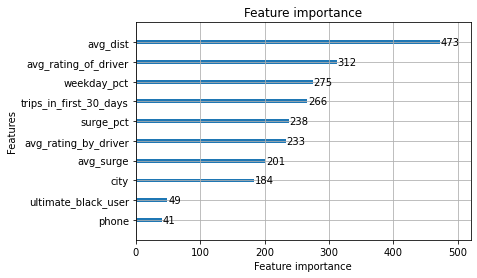

In [28]:
lgb.plot_importance(best_clf)  #n_iter=50

In [29]:
#graph = lgb.create_tree_digraph(best_clf, tree_index=0,filename='best0')
#graph.render(view=True)

In [30]:
# graph = lgb.create_tree_digraph(best_clf, tree_index=22,filename='best0')
# graph.render(view=True)

## find best threshold

Threshold:  0.15
f1 Score:  0.6853840702175218
Threshold:  0.16
f1 Score:  0.6911301464492954
Threshold:  0.17
f1 Score:  0.6970733348284368
Threshold:  0.18000000000000002
f1 Score:  0.7018610598096319
Threshold:  0.19000000000000003
f1 Score:  0.7071673535260382
Threshold:  0.20000000000000004
f1 Score:  0.7117127653353604
Threshold:  0.21000000000000005
f1 Score:  0.7164842985499511
Threshold:  0.22000000000000006
f1 Score:  0.7199087963518541
Threshold:  0.23000000000000007
f1 Score:  0.7239110569600974
Threshold:  0.24000000000000007
f1 Score:  0.7271212588707189
Threshold:  0.2500000000000001
f1 Score:  0.7301517896183397
Threshold:  0.2600000000000001
f1 Score:  0.7336562509893311
Threshold:  0.27000000000000013
f1 Score:  0.7366900933859631
Threshold:  0.28000000000000014
f1 Score:  0.7396717048594182
Threshold:  0.29000000000000015
f1 Score:  0.7417148869016307
Threshold:  0.30000000000000016
f1 Score:  0.7441349705500648
Threshold:  0.31000000000000016
f1 Score:  0.7455102934

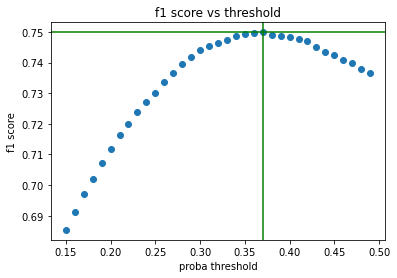

Best threshold, f1_score: 0.370, 0.750 


In [31]:

ytrainprob = best_clf.predict_proba(X_train)[:,1]
 
thresharray = np.arange(0.15, 0.5, 0.01)
thresh_list = list(thresharray)

f1array = [] 
for threshold in thresh_list:
    print("Threshold: ", threshold) 
    
    ypred = ytrainprob > threshold

    f1 = f1_score(y_train, ypred)
    f1array.append(f1)
    print('f1 Score: ', f1)


index = np.argmax(f1array)  

best_threshold = thresharray[index]
best_f1 = f1array[index]

plt.scatter(thresharray, f1array)
plt.title('f1 score vs threshold')
plt.xlabel('proba threshold')
plt.ylabel('f1 score')
plt.axvline(best_threshold, color='green')
plt.axhline(best_f1, color='green')
plt.show()

print('Best threshold, f1_score: {t:.3f}, {f:.3f} '.format(t=best_threshold, f=best_f1)  )   
 

# run model on Test data

In [32]:
ytestprob = best_clf.predict_proba(X_test)[:,1]

ytestpred = ytestprob > best_threshold

f1Test = f1_score(y_test, ytestpred)

print('f1 Test Score: ', f1Test)



f1 Test Score:  0.7281098275573414


In [33]:
sum(y_test), sum (ytestpred)

(5632, 6314)

In [34]:
len(y_test)

15000

In [35]:
# Accuracy
np.mean(y_test == ytestpred)

0.7834666666666666

# SVM.SVC

reference: 
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [36]:
# run with probability, rather classification

import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
clf = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='auto', kernel='rbf', max_iter=-1, probability=True,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [37]:
clf_predict_proba = clf.predict_proba(X_test)
clf_predict_proba

array([[0.91397155, 0.08602845],
       [0.64395127, 0.35604873],
       [0.79867348, 0.20132652],
       ...,
       [0.56049928, 0.43950072],
       [0.13933408, 0.86066592],
       [0.21233904, 0.78766096]])

In [38]:
predBoolSvc = clf_predict_proba[:,1] > best_threshold

f1svc = f1_score(y_test, predBoolSvc)
print('f1 Test Score: ', f1svc)

f1 Test Score:  0.6954880460183355


==> f1 score for svm (0.691) is  worse than that for lgbm (.726)

# Deep Learning Model

In [39]:
from keras.utils import to_categorical

In [40]:
target = to_categorical(y_train)
target

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [41]:
n_cols = X_train.shape[1]

In [42]:
# model 0
m0 = Sequential()

m0.add(Dense(16, activation='relu', input_shape = (n_cols,)))
m0.add(Dense(16, activation='relu'))
# model.add(Dense(32, activation='relu', input_shape = (n_cols,)))
m0.add(Dense(2, activation='softmax'))



In [43]:
# model 1
m1 = Sequential()

m1.add(Dense(32, activation='relu', input_shape = (n_cols,)))
m1.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu', input_shape = (n_cols,)))
m1.add(Dense(2, activation='softmax'))



In [44]:
# model 2
m2 = Sequential()

m2.add(Dense(50, activation='relu', input_shape = (n_cols,)))
m2.add(Dense(50, activation='relu'))

# model.add(Dense(32, activation='relu', input_shape = (n_cols,)))
m2.add(Dense(2, activation='softmax'))



In [45]:
# model 3
m3 = Sequential()

m3.add(Dense(32, activation='relu', input_shape = (n_cols,)))
m3.add(Dense(50, activation='relu'))
 
# model.add(Dense(32, activation='relu', input_shape = (n_cols,)))
m3.add(Dense(2, activation='softmax'))



In [46]:
# model 4
m4 = Sequential()

m4.add(Dense(50, activation='relu', input_shape = (n_cols,)))

m4.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu', input_shape = (n_cols,)))
m4.add(Dense(2, activation='softmax'))



In [47]:
# model 5
m5 = Sequential()

m5.add(Dense(50, activation='relu', input_shape = (n_cols,)))
m5.add(Dense(50, activation='relu'))
m5.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu', input_shape = (n_cols,)))
m5.add(Dense(2, activation='softmax'))



In [48]:
# model 6
m6 = Sequential()

m6.add(Dense(50, activation='relu', input_shape = (n_cols,)))
m6.add(Dense(50, activation='relu'))
m6.add(Dense(50, activation='relu'))
m6.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu', input_shape = (n_cols,)))
m6.add(Dense(2, activation='softmax'))



In [49]:
# model 7
m7 = Sequential()

m7.add(Dense(50, activation='relu', input_shape = (n_cols,)))
m7.add(Dense(100, activation='relu'))
m7.add(Dense(100, activation='relu'))
m7.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu', input_shape = (n_cols,)))
m7.add(Dense(2, activation='softmax'))



In [50]:
# model 8
m8 = Sequential()

m8.add(Dense(50, activation='relu', input_shape = (n_cols,)))
m8.add(Dense(100, activation='relu'))
m8.add(Dense(100, activation='relu'))
m8.add(Dense(100, activation='relu'))
m8.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu', input_shape = (n_cols,)))
m8.add(Dense(2, activation='softmax'))


In [51]:
m7.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 50)                550       
_________________________________________________________________
dense_26 (Dense)             (None, 100)               5100      
_________________________________________________________________
dense_27 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_28 (Dense)             (None, 32)                3232      
_________________________________________________________________
dense_29 (Dense)             (None, 2)                 66        
Total params: 19,048
Trainable params: 19,048
Non-trainable params: 0
_________________________________________________________________


In [52]:
def dnnModel(model, X_train, target, y_test, best_threshold, num_epochs=10):
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=(['accuracy']))
    #h1 = model.fit(X_train, target, batch_size=100)
    #h1 = model.fit(X_train, target, batch_size=None, epochs=100, steps_per_epoch=5 )
    
    
    h1 = model.fit(X_train, target, batch_size=None, epochs=num_epochs, steps_per_epoch=5,  
                   validation_split=0.1, validation_steps = 1,
                   callbacks=[es],
                   verbose=False
                  )
    
    
    print(h1.history)
    
    predictions = model.predict(X_test)
 
    
    predBool = predictions[:,1] > best_threshold
 
    f1DNN = f1_score(y_test, predBool)
    print('f1 Test Score: ', f1DNN)
    return f1DNN
    

In [53]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5,
                   restore_best_weights=True)

In [54]:
num_epochs = 250
dnn_results = []

#for model in [m1, m2]:
for model in [m1, m2, m3, m4, m5, m6, m7, m8]:
    
    print(model.summary())
    f1 = dnnModel(model, X_train, target, y_test, best_threshold, num_epochs)
    dnn_results.append(f1)
dnn_results

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                352       
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 66        
Total params: 1,474
Trainable params: 1,474
Non-trainable params: 0
_________________________________________________________________
None

{'val_loss': [1.846315860748291, 1.5131551027297974, 1.6260898113250732, 0.8131711483001709, 0.8870733976364136, 0.6835383176803589, 0.7451121807098389, 0.6711806654930115, 0.6609532237052917, 0.6272690892219543, 0.6386562585830688, 0.615469217300415, 0.6151034235954285, 0.6096413731575012, 0.6061453819274902, 0.600709080696106, 0.5975947380065918, 0.5955579876899719, 0.592

f1 Test Score:  0.6694615700780928
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 50)                550       
_________________________________________________________________
dense_8 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 102       
Total params: 3,202
Trainable params: 3,202
Non-trainable params: 0
_________________________________________________________________
None
Restoring model weights from the end of the best epoch
Epoch 00161: early stopping
{'val_loss': [1.5767626762390137, 0.7859771251678467, 0.7931116819381714, 0.7553560137748718, 0.7047459483146667, 0.6285358667373657, 0.6140586733818054, 0.6138846278190613, 0.602087676525116, 0.5986506938934326, 0.5887881517410278, 0.587607204914093, 0.58371

f1 Test Score:  0.6793224777023158
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 32)                352       
_________________________________________________________________
dense_11 (Dense)             (None, 50)                1650      
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 102       
Total params: 2,104
Trainable params: 2,104
Non-trainable params: 0
_________________________________________________________________
None
{'val_loss': [4.8668951988220215, 1.1546475887298584, 2.156000852584839, 1.767730474472046, 0.7889981865882874, 1.0142676830291748, 0.6600515246391296, 0.784390389919281, 0.6436452865600586, 0.6746829748153687, 0.6273765563964844, 0.6432910561561584, 0.6196826100349426, 0.6173227429389954, 0.6137434244155884, 0.6055497527122498, 0.601439237

f1 Test Score:  0.6834670947030498
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 50)                550       
_________________________________________________________________
dense_14 (Dense)             (None, 32)                1632      
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 66        
Total params: 2,248
Trainable params: 2,248
Non-trainable params: 0
_________________________________________________________________
None
Restoring model weights from the end of the best epoch
Epoch 00182: early stopping
{'val_loss': [4.222135066986084, 1.8209881782531738, 1.1214498281478882, 0.9653484225273132, 0.8206468820571899, 0.8151196241378784, 0.7407863140106201, 0.7031225562095642, 0.6798639297485352, 0.6426764726638794, 0.6223025918006897, 0.6003140211105347, 0.5940

f1 Test Score:  0.6732673267326733
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 50)                550       
_________________________________________________________________
dense_17 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_18 (Dense)             (None, 32)                1632      
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 66        
Total params: 4,798
Trainable params: 4,798
Non-trainable params: 0
_________________________________________________________________
None
Restoring model weights from the end of the best epoch
Epoch 00157: early stopping
{'val_loss': [1.089558482170105, 0.8957498669624329, 0.7864908576011658, 0.7121832966804504, 0.657961368560791, 0.6352345943450

f1 Test Score:  0.699138991389914
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 50)                550       
_________________________________________________________________
dense_21 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_22 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_23 (Dense)             (None, 32)                1632      
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 66        
Total params: 7,348
Trainable params: 7,348
Non-trainable params: 0
_________________________________________________________________
None
Restoring model weights from the end of the best epoch
Epoch 00094: early stopp

Restoring model weights from the end of the best epoch
Epoch 00082: early stopping
{'val_loss': [1.113214373588562, 0.900466799736023, 0.7746447920799255, 0.6882971525192261, 0.6319048404693604, 0.6137747168540955, 0.5979337096214294, 0.5935583710670471, 0.583829402923584, 0.5812191367149353, 0.5797799825668335, 0.5788663625717163, 0.5763251185417175, 0.5748502612113953, 0.5724284052848816, 0.5707494616508484, 0.5688019394874573, 0.5655924081802368, 0.5645316243171692, 0.5614409446716309, 0.559557318687439, 0.558695912361145, 0.555926501750946, 0.5555023550987244, 0.5520857572555542, 0.5492383241653442, 0.5478949546813965, 0.5460858941078186, 0.5475902557373047, 0.5456744432449341, 0.542227029800415, 0.5426245927810669, 0.5400766730308533, 0.5440980792045593, 0.5380849242210388, 0.5377835631370544, 0.5368051528930664, 0.5372393131256104, 0.5360080003738403, 0.5340842008590698, 0.5379381775856018, 0.5327582955360413, 0.535075306892395, 0.5318495035171509, 0.538503110408783, 0.5365413427

f1 Test Score:  0.6696464851686306


[0.6694615700780928,
 0.6793224777023158,
 0.6834670947030498,
 0.6732673267326733,
 0.699138991389914,
 0.6764821667585229,
 0.6746018980215539,
 0.6696464851686306]

In [55]:
# 250 epochs
dnn_results

[0.6694615700780928,
 0.6793224777023158,
 0.6834670947030498,
 0.6732673267326733,
 0.699138991389914,
 0.6764821667585229,
 0.6746018980215539,
 0.6696464851686306]

In [56]:
# best DNN model, f1 score

f1_best_dnn = max(dnn_results)
best_dnn_model = np.argmax(dnn_results)
best_dnn_model, f1_best_dnn

(4, 0.699138991389914)

==> the best DNN model (f1=0.704) is not as good as the lgb model  (f1=0.743)

In [57]:
# evaluate best model

best_model = m2

predictions_dnn = best_model.predict(X_test)


predBoolDnn = predictions_dnn[:,1] > best_threshold

f1DNN = f1_score(y_test, predBoolDnn)
print('f1 Test Score: ', f1DNN)





f1 Test Score:  0.6793224777023158


# Compare Confusion Matrixes for Models

In [58]:
def plot_confusion (y_test, y_pred, model_label):
    from sklearn.metrics import confusion_matrix 
    import seaborn as sns
    cf_matrix = confusion_matrix(y_test, y_pred)
    print(cf_matrix)


    fig = plt.figure(figsize = (7, 7))
    sns.heatmap(cf_matrix.astype(int), annot=True,  square=True
    #            , cmap = 'coolwarm'
                , xticklabels = ['not retained', 'retained']
                , yticklabels = ['not retained', 'retained']).set_title(model_label)

[[7403 1965]
 [1283 4349]]
[[7743 1625]
 [1763 3869]]
[[6930 2438]
 [1481 4151]]


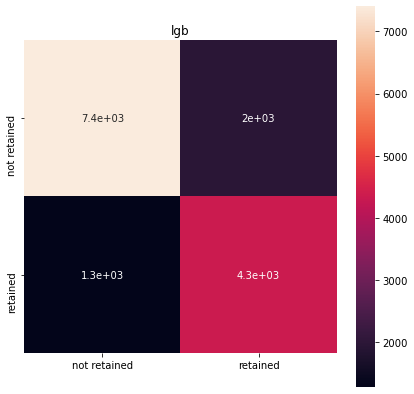

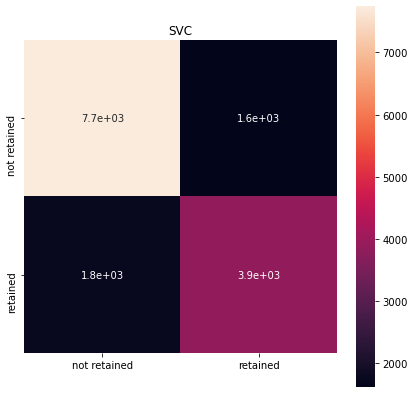

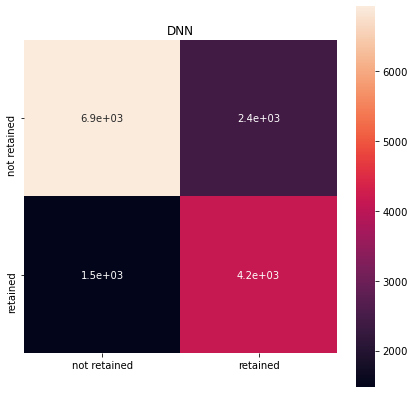

In [59]:
# plot models

plot_confusion(y_test, ytestpred, 'lgb')
plot_confusion(y_test, predBoolSvc, 'SVC')
plot_confusion(y_test, predBoolDnn, 'DNN')
